In [1]:
import pandas as pd
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from keras.layers import LSTM, Dense,Input,Layer
from keras import backend as K,Model
from numpy.random import seed
from imblearn.under_sampling import RandomUnderSampler 
seed(0)
import os
os.environ['PYTHONHASHSEED']=str(0)
import tensorflow as tf
tf.random.set_seed(0)
import random
import random as python_random
python_random.seed(0)
random.seed(0)

In [2]:
data = pd.read_csv('creditcard.csv', na_filter=True)

data.drop(['Time'], axis=1, inplace=True)
selected_vars =['V4','V14','V10','V16','V9','V12','V11','V17','V7','V21','V18','V8','V1','V3','V6','V2','V27','V5','V26','Class']


In [3]:
tr_data = data[selected_vars]
tr_data.shape

(284807, 20)

In [4]:
X = tr_data.drop(['Class'], axis = 'columns')
Label_Data = tr_data['Class']

In [5]:
y=tr_data['Class']

In [6]:
from sklearn.preprocessing import StandardScaler
## Standardizing the data
X=pd.DataFrame(StandardScaler().fit_transform(X))

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, shuffle=False,random_state=0)
from sklearn.linear_model import SGDOneClassSVM
df1_normal=X_train[y_train==0]
clf = SGDOneClassSVM(nu=0.01,random_state=0)
res = clf.fit_predict(df1_normal)
print(len(res[res==-1]))
res[res==1] = 0
res[res==-1] = 1
ros = RandomUnderSampler(sampling_strategy=0.95)
ros.fit_resample(df1_normal,res)
index=ros.sample_indices_
X_train.drop(X_train.index[index], inplace=True)
y_train.drop(y_train.index[index], inplace=True)

2155


In [8]:
X_train.shape

(194941, 19)

In [9]:
X_test.shape

(85443, 19)

In [10]:
# X_train et X_test sont des dataframe qui contient les features
train_LSTM_X=X_train.to_numpy()
test_LSTM_X=X_test.to_numpy()

## Reshape input to be 3D [samples, timesteps, features] (format requis par LSTM)
train_LSTM_X = train_LSTM_X.reshape((train_LSTM_X.shape[0], 1, train_LSTM_X.shape[1]))
test_LSTM_X = test_LSTM_X.reshape((test_LSTM_X.shape[0], 1, test_LSTM_X.shape[1]))

## Recuperation des labels
train_LSTM_y=y_train
test_LSTM_y=y_test

In [11]:
inputs=Input((1,19))
x1=LSTM(50)(inputs)
outputs=Dense(1,activation='sigmoid')(x1)
model=Model(inputs,outputs)

In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Precision','Recall'])

In [13]:
history=model.fit(train_LSTM_X, train_LSTM_y,epochs=4,batch_size=400,validation_data=(test_LSTM_X, test_LSTM_y))

Epoch 1/4
488/488 [==============================] - 6s 8ms/step - loss: 0.1656 - precision: 0.0559 - recall: 0.5734 - val_loss: 0.0218 - val_precision: 0.9412 - val_recall: 0.5926
Epoch 2/4
488/488 [==============================] - 3s 6ms/step - loss: 0.0088 - precision: 0.8644 - recall: 0.7590 - val_loss: 0.0070 - val_precision: 0.9524 - val_recall: 0.7407
Epoch 3/4
488/488 [==============================] - 3s 6ms/step - loss: 0.0046 - precision: 0.8896 - recall: 0.8033 - val_loss: 0.0043 - val_precision: 0.9500 - val_recall: 0.7037
Epoch 4/4
488/488 [==============================] - 3s 6ms/step - loss: 0.0035 - precision: 0.9111 - recall: 0.7950 - val_loss: 0.0032 - val_precision: 0.9419 - val_recall: 0.7500


In [14]:
# predict probabilities for test set
yhat_probs = model.predict(test_LSTM_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]> 0.5

In [15]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_LSTM_y, yhat_probs)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_LSTM_y, yhat_probs)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_LSTM_y, yhat_probs)
print('Recall: %f' % recall)
f1 = f1_score(test_LSTM_y, yhat_probs)
print('f1: %f' % f1)

Accuracy: 0.999625
Precision: 0.941860
Recall: 0.750000
f1: 0.835052


In [16]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [17]:
cm = confusion_matrix(y_true=test_LSTM_y, y_pred=yhat_probs)

In [18]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
labels = ['Normal','Fraud']

Confusion matrix, without normalization
[[85330     5]
 [   27    81]]


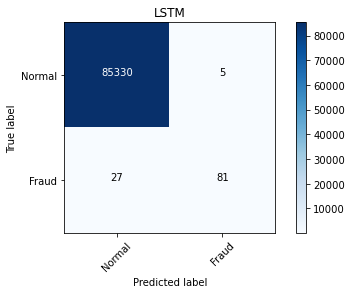

In [19]:
plot_confusion_matrix(cm=cm, classes=labels, title='LSTM')

In [20]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [21]:
inputs1=Input((1,19))
att_in=LSTM(50,return_sequences=True)(inputs1)
att_out=attention()(att_in)
outputs1=Dense(1,activation='sigmoid',trainable=True)(att_out)
model1=Model(inputs1,outputs1)

In [22]:
model1.compile(loss='binary_crossentropy', optimizer='adam',metrics=['Precision','Recall'])

In [23]:
history1=model1.fit(train_LSTM_X, train_LSTM_y,epochs=5,batch_size=500)

Epoch 1/5
390/390 [==============================] - 5s 5ms/step - loss: 0.1909 - precision: 0.0554 - recall: 0.6260
Epoch 2/5
390/390 [==============================] - 2s 5ms/step - loss: 0.0119 - precision: 0.8703 - recall: 0.7618
Epoch 3/5
390/390 [==============================] - 2s 5ms/step - loss: 0.0057 - precision: 0.8800 - recall: 0.7922
Epoch 4/5
390/390 [==============================] - 2s 5ms/step - loss: 0.0041 - precision: 0.8984 - recall: 0.7839
Epoch 5/5
390/390 [==============================] - 2s 5ms/step - loss: 0.0034 - precision: 0.9031 - recall: 0.8006


In [24]:
# predict probabilities for test set
yhat_probs1 = model1.predict(test_LSTM_X, verbose=0)
# reduce to 1d array
yhat_probs1 = yhat_probs1[:, 0]> 0.5

In [25]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_LSTM_y, yhat_probs1)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_LSTM_y, yhat_probs1)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_LSTM_y, yhat_probs1)
print('Recall: %f' % recall)
f1 = f1_score(test_LSTM_y, yhat_probs1)
print('f1: %f' % f1)

Accuracy: 0.999649
Precision: 0.975610
Recall: 0.740741
f1: 0.842105


In [26]:
cm1 = confusion_matrix(y_true=test_LSTM_y, y_pred=yhat_probs1)

Confusion matrix, without normalization
[[85333     2]
 [   28    80]]


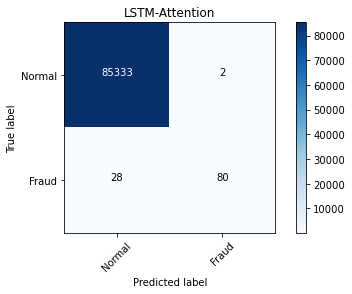

In [27]:
plot_confusion_matrix(cm=cm1, classes=labels, title='LSTM-Attention', normalize=False)